# Figure 6 - Stratified analysis of variability
The goal of the notebook is to assess whether there are differences of anti-HLA kinetics within stratified subgroups of patients.

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import datetime

In [2]:
# Load MFI values
filename = "data/MFI_with_RS_new_filtering.csv"
df_filtered = pd.read_csv(filename, encoding = "latin").set_index('RSNR', drop=False)


In [3]:
# Load covariates
df_covariates = pd.read_csv('data/processed_patients_covariates.csv')


In [4]:
# 4 categories for the immnunological status:
# 1. Had previous transplant
# 2. No prev transplant but pregnant
# 3. No prev transplant, no pregnancy but transfusion
# 4. None of above
transplanted_ids = set(df_covariates.loc[df_covariates['prev_transplant']==1, 'RSNR'])
pregnant_ids = set(df_covariates.loc[df_covariates['pregnant']==1, 'RSNR'])
transfused_ids = set(df_covariates.loc[df_covariates['transfusion']==1, 'RSNR'])

true_preg_ids = pregnant_ids.difference(transplanted_ids)
true_transf_ids = transfused_ids.difference(pregnant_ids).difference(transplanted_ids)
category_4 = set(df_filtered['RSNR'].unique()).difference(transfused_ids).difference(pregnant_ids).difference(transplanted_ids)


print(f"There are {len(transplanted_ids)} patients in category 1. {len(true_preg_ids)} in category 2."+
     f" {len(true_transf_ids)} in category 3 and {len(category_4)} for category 4")

There are 115 patients in category 1. 98 in category 2. 81 in category 3 and 173 for category 4


In [5]:
# Add date of first transplant
df_map = pd.read_csv("data/RS_nummer_age_sex.csv",index_col=0)
df_map_filtered = df_map[[rs in df_filtered.index.unique() for rs in df_map.index.unique()]]
new_df_covariates = df_map_filtered.copy()
patient_ids = list(df_map_filtered.index)
first_date = []
yob = []
for rs_id in patient_ids:
    if df_filtered.loc[rs_id, 'TPLDAT'].nunique() > 1:
        print("WARNING: {} has multiple transplant dates: {}".format(rs_id, df_filtered.loc[rs_id, 'TPLDAT'].unique()))
    dates = [datetime.datetime.strptime(d, '%d.%m.%Y') for d in df_filtered.loc[rs_id, 'IL_DAT'].unique()]
    first_date.append(min(dates))
    yob.append(datetime.datetime.strptime(str(df_map_filtered.loc[rs_id, 'Unnamed: 1']), '%Y'))
    
new_df_covariates.loc[:,'FIRSDAT'] = first_date
new_df_covariates.loc[:,'YOB'] = yob
new_df_covariates.drop(columns=['Unnamed: 1'], inplace=True)


from dateutil.relativedelta import relativedelta
def td_to_float(td):
    return td.years + td.months/12 + td.days/365
for i in new_df_covariates.index:
    new_df_covariates.at[i, 'age_at_firstdate'] = td_to_float(relativedelta(new_df_covariates.loc[i, 'FIRSDAT'], new_df_covariates.loc[i, 'YOB']))


for i, cat in enumerate([transplanted_ids, true_preg_ids, true_transf_ids, category_4]):#, category_5]):
    for j in cat:
        new_df_covariates.at[j, 'immuno_category'] = int(i)

In [6]:
df_covariates[df_covariates['transfusion'] == 1].groupby('gender').count()

,RSNR,yob,prev_transplant,pregnant,transfusion
gender,,,,,
0,89,89,89,89,89
1,96,96,96,96,96


In [7]:
new_df_covariates.groupby(['Sex','immuno_category']).count()

FIRSDAT  YOB  age_at_firstdate
Sex    immuno_category                                
Female 0.0                   45   45                45
       1.0                   98   98                98
       2.0                   21   21                21
       3.0                   38   38                38
Male   0.0                   70   70                70
       2.0                   60   60                60
       3.0                  135  135               135

In [8]:
# Load the MFI values
from utils import get_evolution_df, get_time_series, filter_patients

ALL_ABS_TYP1 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse1']['I_NAM'].unique()
ALL_ABS_TYP2 = df_filtered[df_filtered['TYP']=='Lumi-Single-Klasse2']['I_NAM'].unique()
ALL_ABS = df_filtered['I_NAM'].unique()

df_filtered_typ1 = filter_patients(df_filtered)
df_filtered_typ2 = filter_patients(df_filtered, analysis_type='2')
df_filtered_typ1['RSNR'].nunique()

17 patients need to be excluded as they only have one date of measurements.
20 patients need to be excluded as they only have one date of measurements.


/Volumes/tomatteo$/Projects/HLAvariability/utils.py:39: FutureWarning: 'RSNR' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  df_n = df_filtered_typ.groupby('RSNR')['IL_DAT'].nunique()
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]
/Volumes/tomatteo$/Projects/HLAvariability/utils.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_filtered_typ = df_filtered_typ.set_index('RSNR', drop=False)[df_n>1]


438

In [9]:
def is_there_passage(x1_l,x2_l,thr):
    # Returns the signed passage (+1 if goes up, -1 if goes down)
    return np.multiply(np.sign(x2_l-x1_l),np.logical_xor(x1_l<thr, x2_l<thr).astype(int))

# Instead of taking the val difs, check if thresholds are crossed
CLINICAL_THRESHOLD = 1000
CLINICAL_THRESHOLD_2 = 5000
CLINICAL_THRESHOLD_3 = 10000

valdifs = []
kept_ids = []
tdifs = []

valdifs_5000 = []
valdifs_10000 = []
for patid in df_filtered_typ1['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ1.loc[patid], complete=True, analysis_type='1')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs.append(is_there_passage(patient_ts.values[:-1,:],patient_ts.values[1:,:], CLINICAL_THRESHOLD))
        valdifs_5000.append(is_there_passage(patient_ts.values[:-1,:],
                                               patient_ts.values[1:,:], CLINICAL_THRESHOLD_2))
        valdifs_10000.append(is_there_passage(patient_ts.values[:-1,:],
                                               patient_ts.values[1:,:], CLINICAL_THRESHOLD_3))
        kept_ids.append(patid)
    except:
        continue

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Create list of measurements with associated covariates
def create_covariate_df(valdifs, tdifs, kept_ids, df_cov):
    entries = []
    sex_dict = {'Female':0,'Male':1}
    sum_absolute = [np.abs(x).T.sum(axis=0) for x in valdifs]
    for i, vals in enumerate(sum_absolute):
        for j, v in enumerate(vals):
            l = df_cov.loc[kept_ids[i]]
            entry = [kept_ids[i], tdifs[i][j][0], v, sex_dict[l[0]], l[3], l[4]]
            entries.append(entry)
    return pd.DataFrame(entries, columns=['RSNR', 'tdif', 'crossing_nr', 'sex', 'age_at_meas', 'category'])

df_measures = create_covariate_df(valdifs, tdifs, kept_ids, new_df_covariates)

In [11]:
df_measures.head()

,RSNR,tdif,crossing_nr,sex,age_at_meas,category
0,RS-2002-0057,1090.0,11.0,0,32.060274,1.0
1,RS-2002-0057,359.0,4.0,0,32.060274,1.0
2,RS-2002-0057,369.0,1.0,0,32.060274,1.0
3,RS-2002-0057,189.0,1.0,0,32.060274,1.0
4,RS-2002-0057,177.0,3.0,0,32.060274,1.0


In [12]:
# Add quantile info
def age_cat(x):
        if x < 30:
            return 'below 30 years'
        elif x < 60:
            return '30 to 60 years'
        else:
            return 'above 60 years'
def improve_df(df_measures, quantile_labels=['<98 days', '98 - 175 days', '176 - 225 days', '226 - 361 days', '> 361 days']):
    df_measures['percentile'] = pd.qcut(df_measures['tdif'], 5,
                                       labels=quantile_labels)
    
    df_measures['age_category'] = df_measures['age_at_meas'].apply(age_cat)
    df_measures['sex'] = df_measures['sex'].map({1: 'Men', 0: 'Women'})
    df_measures['category'] = df_measures['category'].map({0: 'Previously transplanted',
                                                       1: 'Previously pregnant',
                                                       2: 'Previously transfused',
                                                       3: 'None of the previous',
                                                       4: 'Unknown immunizing history'})
    df_measures.columns=['RSNR', 'tdif', 'Number of threshold crossings', 'sex', 'age_at_meas', 'category',
       'Time between measurements', 'age_category']
    return df_measures

In [13]:
df_measures = improve_df(df_measures)

In [14]:
cubehelix_pal = sns.cubehelix_palette(5, start=.3, rot=-.8, gamma=0.6, hue=0.95, light=0.8, dark=0.1)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


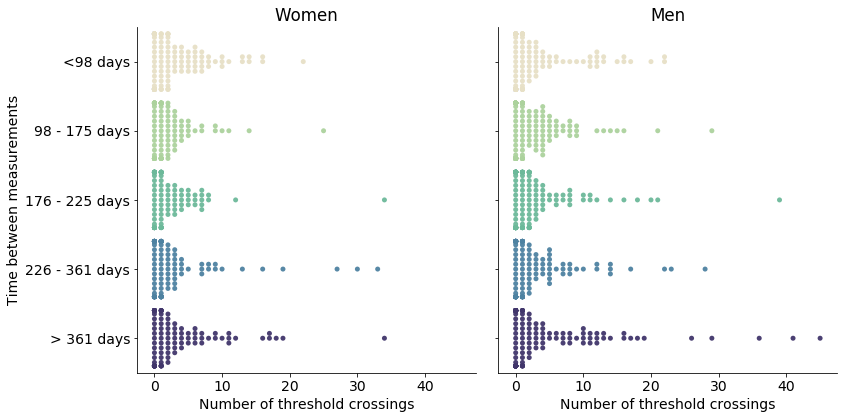

In [15]:
plt.rcParams.update({'font.size': 14})

ax = sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='sex', col_order=['Women','Men'],palette=cubehelix_pal,
                  data=df_measures, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['Women', 'Men']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_sex.png', dpi=200)
plt.savefig('paper/figures/supplementary/stratified_sex.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})

In [16]:
# Statistical tests between the different classes
from scipy.stats import ttest_ind, mannwhitneyu

def conduct_test(df, covariate, categories):
    vs = []
    for c in categories:
        vs.append(df[df[covariate]==c]['Number of threshold crossings'].as_matrix())
    # Conduct the test for each pair
    for i in range(len(categories)):
        for j in range(i+1,len(categories)):
            print('{} vs {}:'.format(categories[i], categories[j]))
            t, p = ttest_ind(vs[i], vs[j], equal_var=False, nan_policy='omit')
            print('\tt-score: {:.3f}, p-val: {:.5f}'.format(t,p))
            
conduct_test(df_measures, 'sex', ['Women', 'Men'])

Women vs Men:
	t-score: -1.098, p-val: 0.27223


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


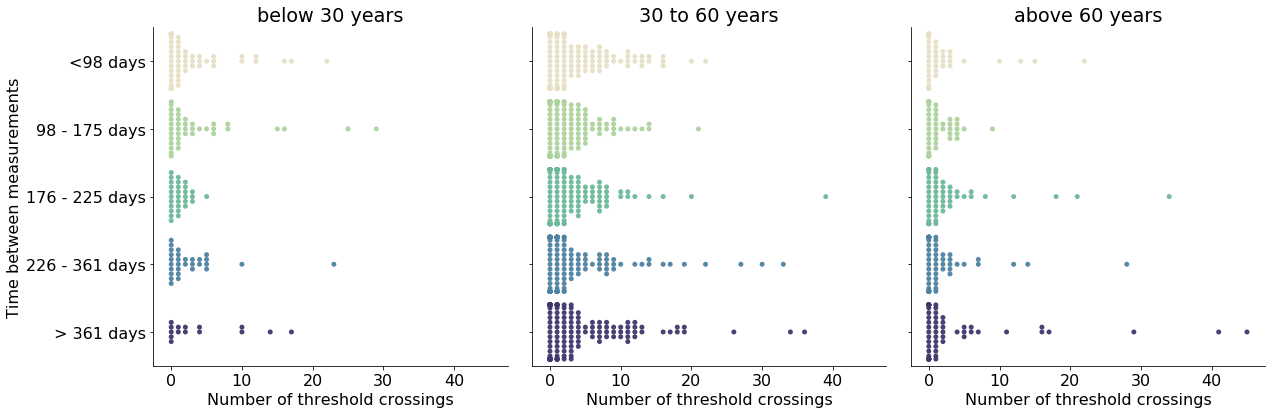

In [17]:
plt.rcParams.update({'font.size': 16})
ax = sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='age_category', 
            col_order=['below 30 years', '30 to 60 years', 'above 60 years'],
            palette=cubehelix_pal, data=df_measures, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['below 30 years', '30 to 60 years', 'above 60 years']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_age.png', dpi=200)
plt.savefig('paper/figures/supplementary/stratified_age.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})

In [18]:
col_order=['below 30 years', '30 to 60 years', 'above 60 years']
conduct_test(df_measures, 'age_category', col_order)

below 30 years vs 30 to 60 years:
	t-score: 0.207, p-val: 0.83580
below 30 years vs above 60 years:
	t-score: 0.599, p-val: 0.54965
30 to 60 years vs above 60 years:
	t-score: 0.569, p-val: 0.56947


In [19]:
def plot_immunizing_catplot(df_measures, filename=None, xlim=(-1,47)):
    plt.rcParams.update({'font.size': 16})

    ax = sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
                hue='Time between measurements', col='category', palette=cubehelix_pal,
                col_order = ['Previously transplanted','Previously pregnant','Previously transfused',
                             'None of the previous'],#'Unknown immunizing history'],
                      data=df_measures, kind='swarm', alpha=0.95, size=6, legend=False)

    for i, n in enumerate(['Previously transplanted', 'Previously pregnant', 'Previously transfused',
                           'No documented immunizing events']):
        ax.axes[0][i].set_title(n)
        ax.axes[0][i].set_xlim(xlim)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(f'{filename}.png', dpi=200)
        plt.savefig(f'{filename}.pdf', dpi=300)
    plt.rcParams.update({'font.size': 12})


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


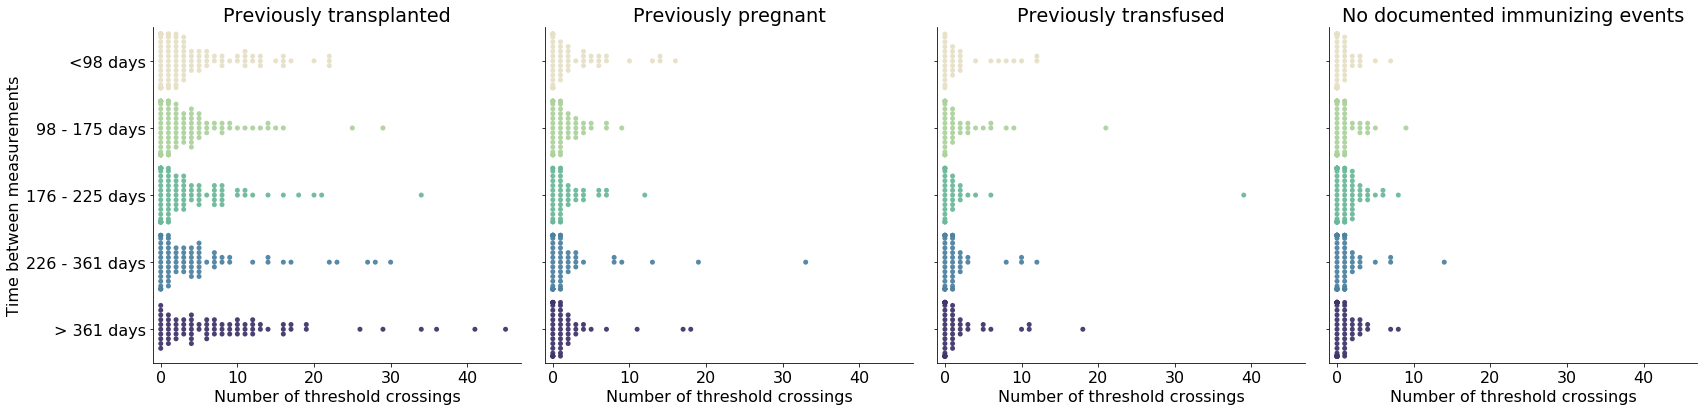

In [20]:
plot_immunizing_catplot(df_measures, 'paper/figures/plots/stratified_immuno_category')

In [21]:
df_measures.groupby('category')['Number of threshold crossings'].median()

category
None of the previous       0.0
Previously pregnant        1.0
Previously transfused      1.0
Previously transplanted    2.5
Name: Number of threshold crossings, dtype: float64

In [22]:
df_measures.groupby('category')['Number of threshold crossings'].mean()

category
None of the previous       0.922388
Previously pregnant        2.094697
Previously transfused      1.908654
Previously transplanted    4.957965
Name: Number of threshold crossings, dtype: float64

In [23]:
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       41.791045
Previously pregnant        59.848485
Previously transfused      51.442308
Previously transplanted    74.115044
dtype: float64

N crossings > 1
category
None of the previous       19.402985
Previously pregnant        34.469697
Previously transfused      27.884615
Previously transplanted    59.292035
dtype: float64

N crossings > 3
category
None of the previous        6.567164
Previously pregnant        17.424242
Previously transfused      13.942308
Previously transplanted    42.256637
dtype: float64

N crossings > 5
category
None of the previous        2.985075
Previously pregnant        10.606061
Previously transfused      11.057692
Previously transplanted    29.424779
dtype: float64



In [24]:
# Only upward changes
def create_covariate_df_ups(valdifs, tdifs, kept_ids, df_cov):
    entries = []
    sex_dict = {'Female':0,'Male':1}
    sum_up = [(x>0).T.sum(axis=0) for x in valdifs]
    for i, vals in enumerate(sum_up):
        for j, v in enumerate(vals):
            l = df_cov.loc[kept_ids[i]]
            entry = [kept_ids[i], tdifs[i][j][0], v, sex_dict[l[0]], l[3], l[4]]
            entries.append(entry)
    return pd.DataFrame(entries, columns=['RSNR', 'tdif', 'crossing_nr', 'sex', 'age_at_meas', 'category'])

In [25]:
df_measures_up = improve_df(create_covariate_df_ups(valdifs, tdifs, kept_ids, new_df_covariates))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


In [26]:
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_up.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       22.985075
Previously pregnant        34.848485
Previously transfused      33.173077
Previously transplanted    46.902655
dtype: float64

N crossings > 1
category
None of the previous        9.850746
Previously pregnant        16.666667
Previously transfused      16.346154
Previously transplanted    32.522124
dtype: float64

N crossings > 3
category
None of the previous        2.985075
Previously pregnant         6.818182
Previously transfused       6.730769
Previously transplanted    19.469027
dtype: float64

N crossings > 5
category
None of the previous        1.492537
Previously pregnant         4.166667
Previously transfused       4.326923
Previously transplanted    15.265487
dtype: float64



In [27]:
categories = ['Previously transplanted','Previously pregnant','Previously transfused',
                         'None of the previous']
conduct_test(df_measures, 'category', categories)

Previously transplanted vs Previously pregnant:
	t-score: 7.281, p-val: 0.00000
Previously transplanted vs Previously transfused:
	t-score: 7.137, p-val: 0.00000
Previously transplanted vs None of the previous:
	t-score: 12.200, p-val: 0.00000
Previously pregnant vs Previously transfused:
	t-score: 0.506, p-val: 0.61327
Previously pregnant vs None of the previous:
	t-score: 4.701, p-val: 0.00000
Previously transfused vs None of the previous:
	t-score: 3.286, p-val: 0.00116


In [28]:
# General test: combine categories
a = df_measures[df_measures['category']=='None of the previous']['Number of threshold crossings'].as_matrix()
b = df_measures[df_measures['category'].apply(lambda x: x in ['Previously transplanted','Previously pregnant',
                          'Previously transfused'])]['Number of threshold crossings'].as_matrix()

print(ttest_ind(a, b, equal_var=False, nan_policy='omit'))
print(mannwhitneyu(a, b, alternative='two-sided'))

Ttest_indResult(statistic=-12.14315944001539, pvalue=4.017799688772975e-32)
MannwhitneyuResult(statistic=104062.0, pvalue=5.59095366947918e-21)


In [29]:
# Test with 5000
df_measures_5000 = create_covariate_df(valdifs_5000, tdifs, kept_ids, new_df_covariates)
df_measures_5000 = improve_df(df_measures_5000)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


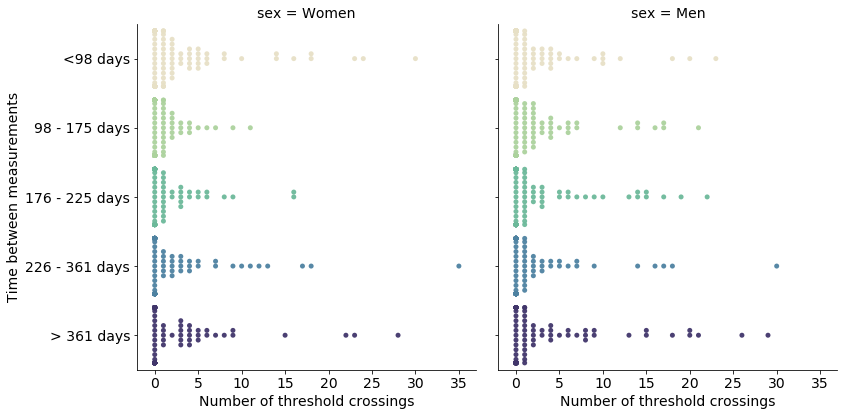

In [30]:
plt.rcParams.update({'font.size': 14})
sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='sex', palette=cubehelix_pal,
                  data=df_measures_5000, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['Women', 'Men']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_sex_5000.png', dpi=200)
plt.savefig('paper/figures/supplementary/stratified_sex_5000.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})


/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


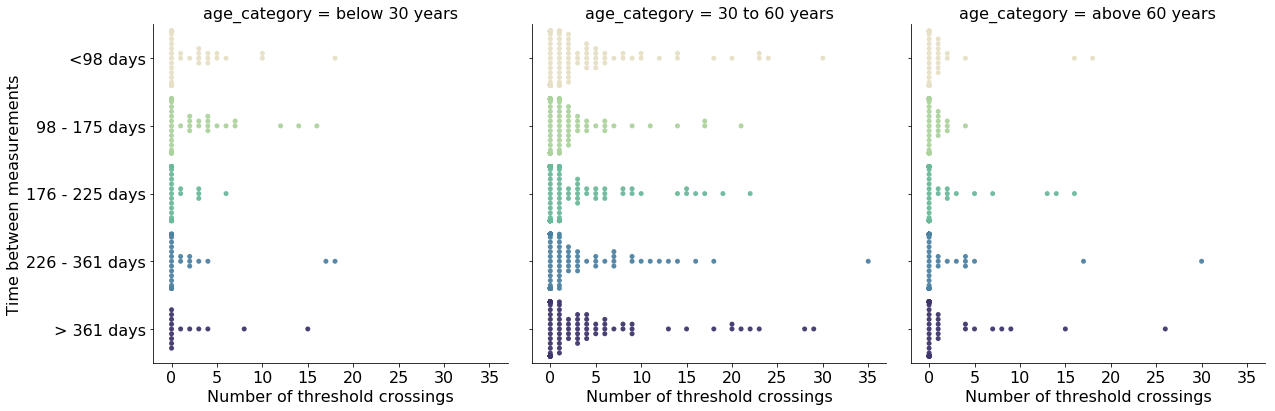

In [31]:
plt.rcParams.update({'font.size': 16})
sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='age_category', 
            col_order=['below 30 years', '30 to 60 years', 'above 60 years'],
            palette=cubehelix_pal, data=df_measures_5000, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['below 30 years', '30 to 60 years', 'above 60 years']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_age_5000.png', dpi=200)
plt.savefig('paper/figures/supplementary/stratified_age_5000.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


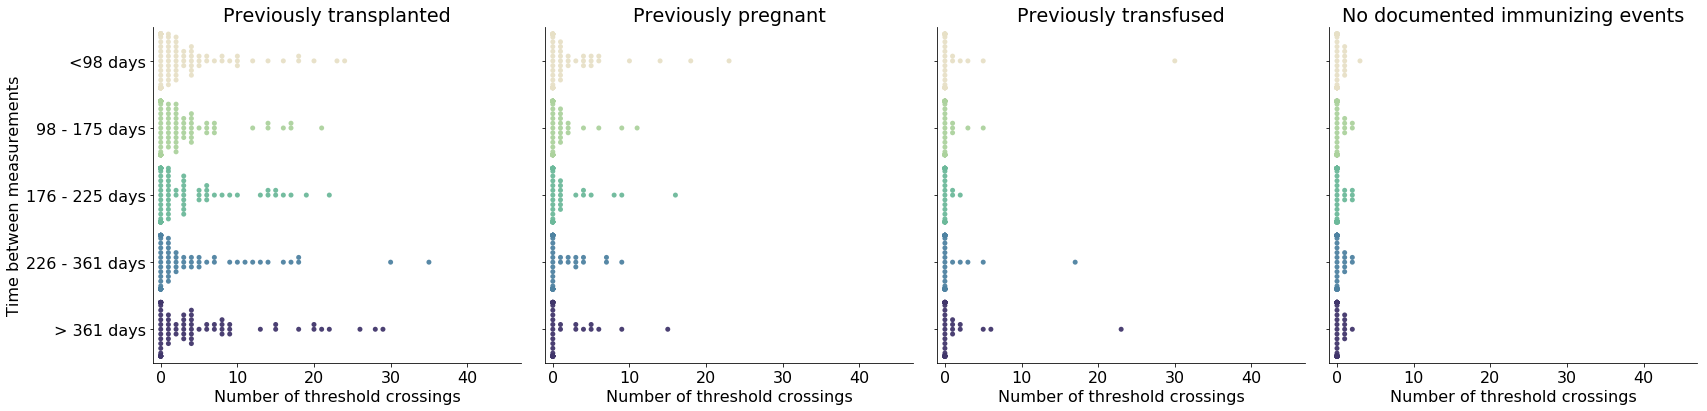

In [32]:
plot_immunizing_catplot(df_measures_5000, 
                        'paper/figures/supplementary/stratified_immuno_category_5000')

In [33]:
conduct_test(df_measures_5000, 'category', categories)

Previously transplanted vs Previously pregnant:
	t-score: 6.163, p-val: 0.00000
Previously transplanted vs Previously transfused:
	t-score: 7.726, p-val: 0.00000
Previously transplanted vs None of the previous:
	t-score: 11.507, p-val: 0.00000
Previously pregnant vs Previously transfused:
	t-score: 2.163, p-val: 0.03107
Previously pregnant vs None of the previous:
	t-score: 5.756, p-val: 0.00000
Previously transfused vs None of the previous:
	t-score: 2.307, p-val: 0.02204


In [34]:
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_5000.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       10.149254
Previously pregnant        28.787879
Previously transfused      13.461538
Previously transplanted    50.663717
dtype: float64

N crossings > 1
category
None of the previous        2.686567
Previously pregnant        18.181818
Previously transfused       7.692308
Previously transplanted    39.380531
dtype: float64

N crossings > 3
category
None of the previous        0.000000
Previously pregnant        12.500000
Previously transfused       3.846154
Previously transplanted    26.548673
dtype: float64

N crossings > 5
category
None of the previous        0.000000
Previously pregnant         6.818182
Previously transfused       1.923077
Previously transplanted    18.584071
dtype: float64



In [35]:
# With 10000
df_measures_10000 = create_covariate_df(valdifs_10000, tdifs, kept_ids, new_df_covariates)
df_measures_10000 = improve_df(df_measures_10000)

for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_10000.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous        1.194030
Previously pregnant        13.636364
Previously transfused       4.326923
Previously transplanted    34.734513
dtype: float64

N crossings > 1
category
None of the previous        0.298507
Previously pregnant         8.333333
Previously transfused       2.403846
Previously transplanted    26.327434
dtype: float64

N crossings > 3
category
None of the previous        0.000000
Previously pregnant         4.545455
Previously transfused       1.923077
Previously transplanted    17.035398
dtype: float64

N crossings > 5
category
None of the previous        0.000000
Previously pregnant         3.030303
Previously transfused       1.923077
Previously transplanted    11.061947
dtype: float64



In [36]:
# Evaluate only upward changes that go from <1000 to >5000 and >10000
one_to_5000 = [((valdifs[i]+valdifs_5000[i])>1).astype(int) for i in range(len(valdifs))]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
df_measures_one_to_5000 = create_covariate_df(one_to_5000, tdifs, kept_ids, new_df_covariates)
df_measures_one_to_5000 = improve_df(df_measures_one_to_5000)

In [38]:
for n in [0, 1]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_one_to_5000.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       0.298507
Previously pregnant        1.515152
Previously transfused      1.923077
Previously transplanted    9.513274
dtype: float64

N crossings > 1
category
None of the previous       0.000000
Previously pregnant        0.378788
Previously transfused      0.000000
Previously transplanted    5.752212
dtype: float64



### Class II

In [39]:
valdifs_2 = []
kept_ids_2 = []
tdifs_2 = []

valdifs_5000_2 = []
valdifs_10000_2 = []
for patid in df_filtered_typ2['RSNR'].unique():
    try: # Skip patients that show issues
        patient_ts = get_evolution_df(df_filtered_typ2.loc[patid], complete=True, analysis_type='2')
        # Get the tdif array, we use days as seconds will lead to too small values upon division
        tdifs_2.append(np.array([float(x.days) for x in patient_ts.index[1:]-patient_ts.index[:-1]]).reshape(-1,1))
        # get the differential values for the
        valdifs_2.append(is_there_passage(patient_ts.values[:-1,:],patient_ts.values[1:,:], CLINICAL_THRESHOLD))
        valdifs_5000_2.append(is_there_passage(patient_ts.values[:-1,:],
                                               patient_ts.values[1:,:], CLINICAL_THRESHOLD_2))
        valdifs_10000_2.append(is_there_passage(patient_ts.values[:-1,:],
                                               patient_ts.values[1:,:], CLINICAL_THRESHOLD_3))
        kept_ids_2.append(patid)
    except:
        continue

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
df_measures_2 = create_covariate_df(valdifs_2, tdifs_2, kept_ids_2, new_df_covariates)

In [41]:
df_measures_2 = improve_df(df_measures_2, quantile_labels=['<97 days', '97 - 175 days', 
                                                           '176 - 225 days', '226 - 362 days', '> 362 days'])

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


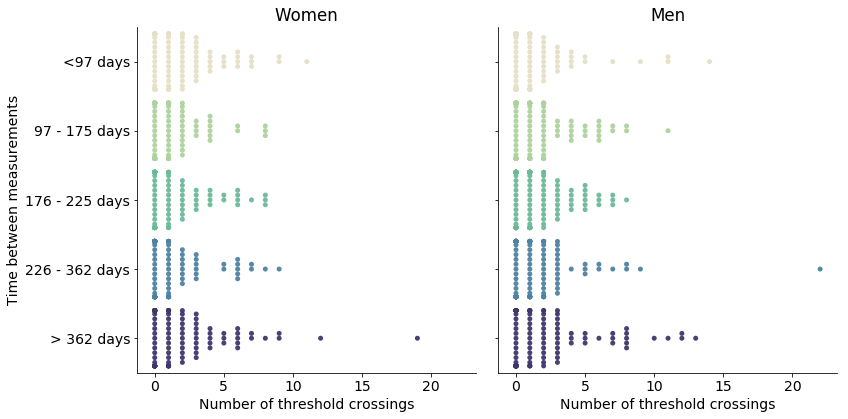

In [42]:
plt.rcParams.update({'font.size': 14})

ax = sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='sex', col_order=['Women','Men'],palette=cubehelix_pal,
                  data=df_measures_2, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['Women', 'Men']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_sex_class2.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


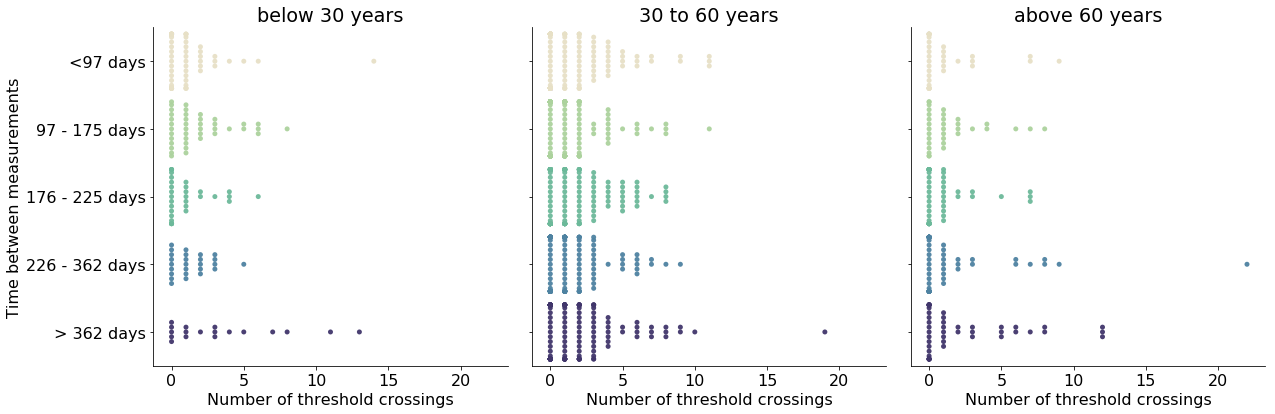

In [43]:
plt.rcParams.update({'font.size': 16})
ax = sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='age_category', 
            col_order=['below 30 years', '30 to 60 years', 'above 60 years'],
            palette=cubehelix_pal, data=df_measures_2, kind='swarm', alpha=0.95, size=6, legend=False)
for i, n in enumerate(['below 30 years', '30 to 60 years', 'above 60 years']):
    ax.axes[0][i].set_title(n)
plt.savefig('paper/figures/supplementary/stratified_age_class2.pdf', dpi=300)

plt.rcParams.update({'font.size': 12})

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


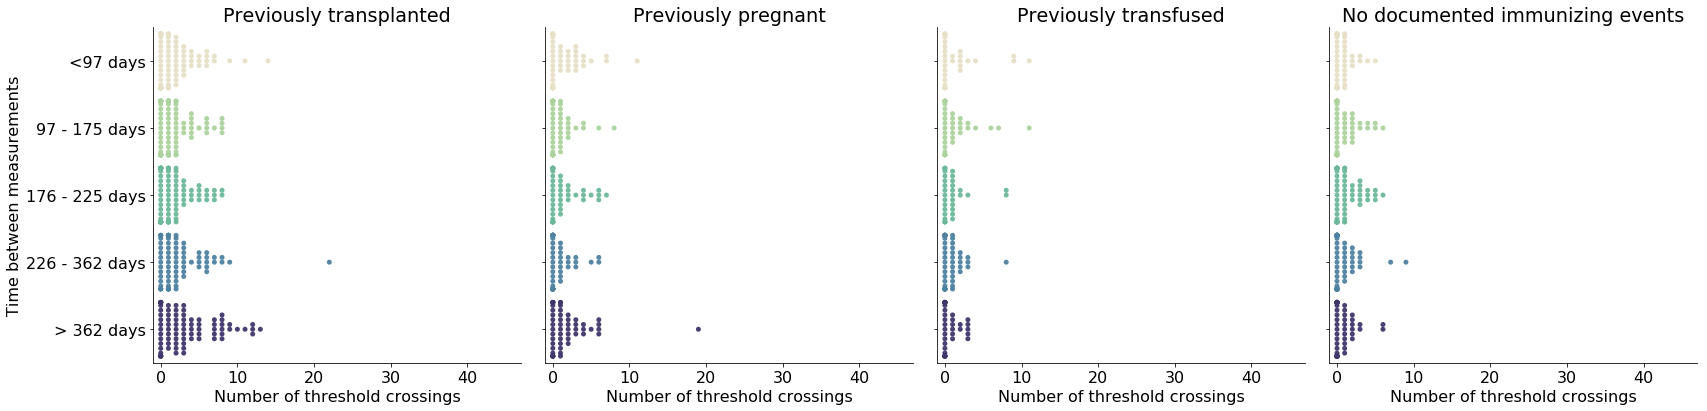

In [44]:
plot_immunizing_catplot(df_measures_2,'paper/figures/plots/stratified_immuno_category_class2')


In [45]:
conduct_test(df_measures_2, 'category', categories)

Previously transplanted vs Previously pregnant:
	t-score: 3.991, p-val: 0.00007
Previously transplanted vs Previously transfused:
	t-score: 5.306, p-val: 0.00000
Previously transplanted vs None of the previous:
	t-score: 7.934, p-val: 0.00000
Previously pregnant vs Previously transfused:
	t-score: 1.349, p-val: 0.17801
Previously pregnant vs None of the previous:
	t-score: 2.880, p-val: 0.00418
Previously transfused vs None of the previous:
	t-score: 1.185, p-val: 0.23707


In [46]:
a = df_measures_2[df_measures_2['category']=='None of the previous']['Number of threshold crossings'].as_matrix()
b = df_measures_2[df_measures_2['category'].apply(lambda x: x in ['Previously transplanted','Previously pregnant',
                          'Previously transfused'])]['Number of threshold crossings'].as_matrix()

print(ttest_ind(a, b, equal_var=False, nan_policy='omit'))
print(mannwhitneyu(a, b, alternative='two-sided'))

Ttest_indResult(statistic=-6.734106236707382, pvalue=2.94683488228463e-11)
MannwhitneyuResult(statistic=109341.5, pvalue=3.6159123504358737e-08)


In [47]:
df_measures_2_5000 = create_covariate_df(valdifs_5000_2, tdifs_2, kept_ids_2, new_df_covariates)
df_measures_2_5000 = improve_df(df_measures_2_5000, quantile_labels=['<97 days', '97 - 175 days', 
                                                           '176 - 225 days', '226 - 362 days', '> 362 days'])

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


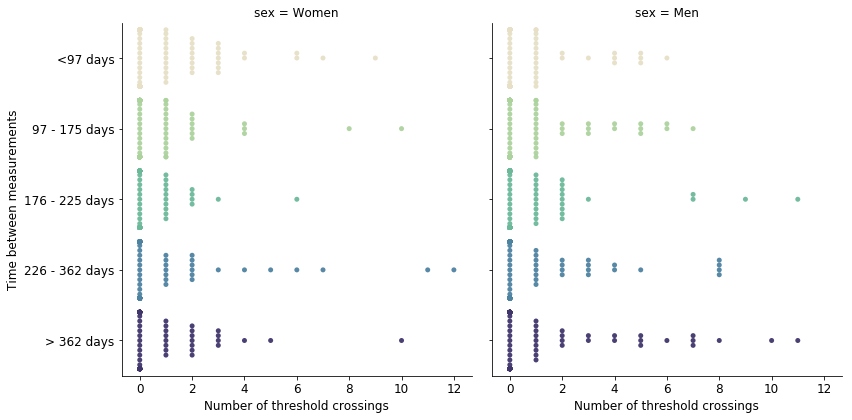

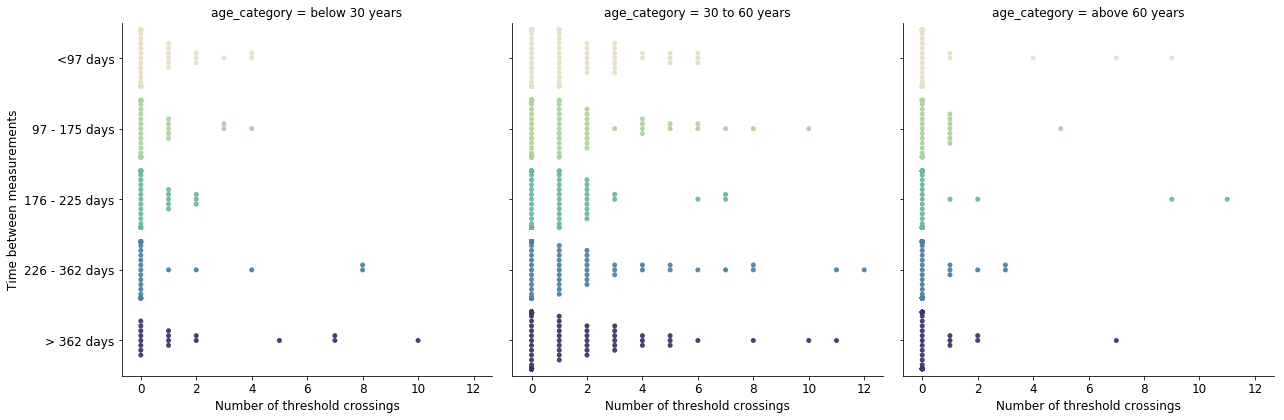

In [48]:
sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='sex', palette=cubehelix_pal,
                  data=df_measures_2_5000, kind='swarm', alpha=0.95, size=6, legend=False)
sns.catplot(x = 'Number of threshold crossings', y='Time between measurements', 
            hue='Time between measurements', col='age_category', 
            col_order=['below 30 years', '30 to 60 years', 'above 60 years'],
            palette=cubehelix_pal, data=df_measures_2_5000, kind='swarm', alpha=0.95, size=6, legend=False)

/usr/local/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


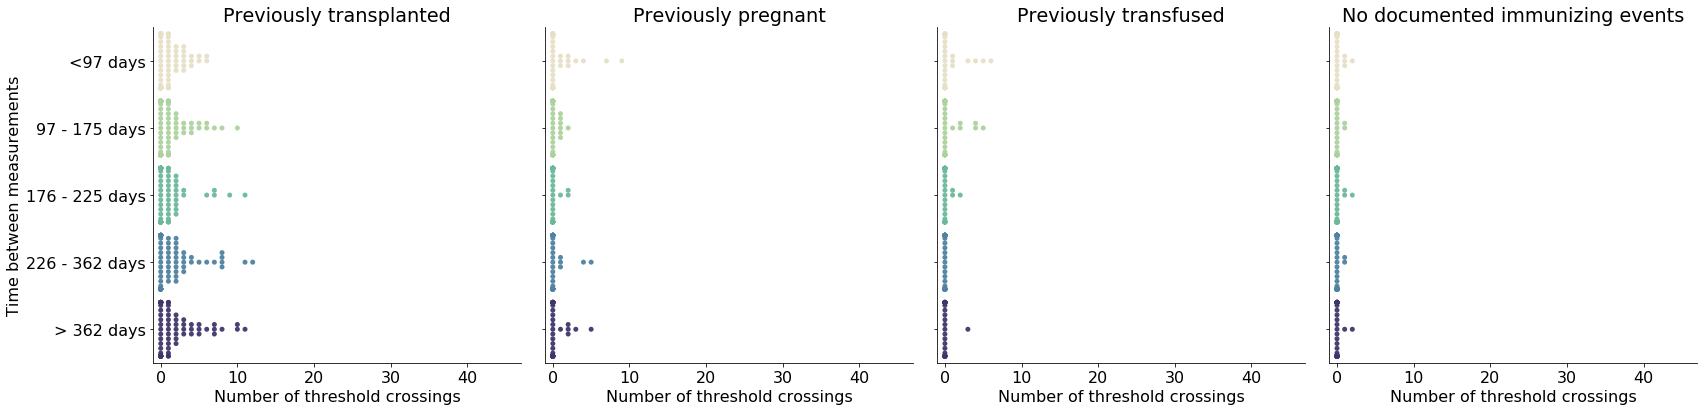

In [49]:
plot_immunizing_catplot(df_measures_2_5000,'paper/figures/supplementary/stratified_immuno_category_5000_2')

In [50]:
conduct_test(df_measures_2_5000, 'category', categories)

Previously transplanted vs Previously pregnant:
	t-score: 7.150, p-val: 0.00000
Previously transplanted vs Previously transfused:
	t-score: 7.452, p-val: 0.00000
Previously transplanted vs None of the previous:
	t-score: 10.777, p-val: 0.00000
Previously pregnant vs Previously transfused:
	t-score: 0.484, p-val: 0.62882
Previously pregnant vs None of the previous:
	t-score: 3.530, p-val: 0.00049
Previously transfused vs None of the previous:
	t-score: 2.762, p-val: 0.00625


In [56]:
# Table S11
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_2.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures_2.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       38.795987
Previously pregnant        47.808765
Previously transfused      42.105263
Previously transplanted    63.419913
dtype: float64

N crossings > 1
category
None of the previous       20.066890
Previously pregnant        27.888446
Previously transfused      21.578947
Previously transplanted    41.125541
dtype: float64

N crossings > 3
category
None of the previous        6.020067
Previously pregnant        12.350598
Previously transfused       5.789474
Previously transplanted    19.913420
dtype: float64

N crossings > 5
category
None of the previous        2.006689
Previously pregnant         6.374502
Previously transfused       4.736842
Previously transplanted    12.121212
dtype: float64



In [57]:
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_2_5000.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures_2.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous        4.347826
Previously pregnant        12.350598
Previously transfused       8.947368
Previously transplanted    39.610390
dtype: float64

N crossings > 1
category
None of the previous        1.003344
Previously pregnant         6.772908
Previously transfused       5.789474
Previously transplanted    22.727273
dtype: float64

N crossings > 3
category
None of the previous        0.000000
Previously pregnant         2.390438
Previously transfused       3.157895
Previously transplanted    10.173160
dtype: float64

N crossings > 5
category
None of the previous       0.000000
Previously pregnant        0.796813
Previously transfused      0.526316
Previously transplanted    6.060606
dtype: float64



In [58]:
df_measures_2_10000 = create_covariate_df(valdifs_10000_2, tdifs_2, kept_ids_2, new_df_covariates)
df_measures_2_10000 = improve_df(df_measures_2_10000, quantile_labels=['<97 days', '97 - 175 days', 
                                                           '176 - 225 days', '226 - 362 days', '> 362 days'])
for n in [0, 1, 3, 5]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_2_10000.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures_2.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous        0.334448
Previously pregnant         7.569721
Previously transfused       1.052632
Previously transplanted    32.251082
dtype: float64

N crossings > 1
category
None of the previous        0.334448
Previously pregnant         3.585657
Previously transfused       1.052632
Previously transplanted    18.398268
dtype: float64

N crossings > 3
category
None of the previous       0.000000
Previously pregnant        0.000000
Previously transfused      0.000000
Previously transplanted    9.307359
dtype: float64

N crossings > 5
category
None of the previous       0.000000
Previously pregnant        0.000000
Previously transfused      0.000000
Previously transplanted    5.411255
dtype: float64



In [54]:
# Evaluate only upward changes that go from <1000 to >5000 and >10000
one_to_5000_2 = [((valdifs_2[i]+valdifs_5000_2[i])>1).astype(int) for i in range(len(valdifs_2))]

df_measures_one_to_5000_2 = create_covariate_df(one_to_5000_2, tdifs_2, kept_ids_2, new_df_covariates)
df_measures_one_to_5000_2 = improve_df(df_measures_one_to_5000_2, quantile_labels=['<97 days', '97 - 175 days', 
                                                           '176 - 225 days', '226 - 362 days', '> 362 days'])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [60]:
for n in [0, 1]:
    print(f'N crossings > {n}')
    print(100*
        df_measures_one_to_5000_2.groupby('category').apply(
            lambda x: (x['Number of threshold crossings']>n).sum())/df_measures_2.groupby('category')['Number of threshold crossings'].count()
    )
    print()

N crossings > 0
category
None of the previous       0.334448
Previously pregnant        1.593625
Previously transfused      1.052632
Previously transplanted    6.709957
dtype: float64

N crossings > 1
category
None of the previous       0.000000
Previously pregnant        1.195219
Previously transfused      0.526316
Previously transplanted    3.030303
dtype: float64

